# SIMULACION CSP Y ANALISIS DE SENSIBILIDAD

In [1]:
import PySAM.TcsmoltenSalt as TCSMS
import PySAM.Lcoefcr as Lcoefcr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Definición de funciones

In [13]:
def configurar_entorno():
    """Define las rutas base, lista de países y crea directorios de salida."""
    # Rutas base - AJUSTA ESTAS RUTAS A TU ENTORNO
    # Intenta usar rutas relativas si es posible

    # Ejemplo de rutas relativas (preferible si la estructura es consistente)
    # datos_base_dir = os.path.join(base_repo_dir, "PRUEBA1", "Datos")
    # output_dir_results = os.path.join(base_repo_dir, "PRUEBA1", "Resultados")
    # output_dir_graphs = os.path.join(base_repo_dir, "PRUEBA1", "graficos")

    # Rutas absolutas (si las relativas no funcionan o prefieres explícitas)
    # Asegúrate que estas rutas existan o sean creadas correctamente
    #datos_base_dir = "/home/nicole/UA/NicoleTorres/PRUEBA1/Datos" # Ajustado a la estructura clonada
    #output_dir_results = "/home/nicole/UA/NicoleTorres/PRUEBA1/Resultados" # Ajustado
    #output_dir_graphs = "/home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp" # Ajustado

    datos_base_dir = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos" # Ajustado a la estructura clonada
    output_dir_results = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados" # Ajustado
    output_dir_graphs = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp"

    # Países a simular (Asegúrate que los archivos CSV existen)
    paises = [
        {"nombre": "Australia", "archivo_sufijo": "australia", "color": "blue"},
        {"nombre": "Chile", "archivo_sufijo": "chile", "color": "red"},
        {"nombre": "Espana", "archivo_sufijo": "espana", "color": "green"}
    ]

    # Crear directorios de salida si no existen
    if not os.path.exists(output_dir_results):
        os.makedirs(output_dir_results)
    if not os.path.exists(output_dir_graphs):
        os.makedirs(output_dir_graphs)

    # Parámetros fijos (se podrían mover a un archivo de config si crecen)
    config_params = {
        "fixed_charge_rate": 0.08,
        "fixed_operating_cost": 1000000,
        "variable_operating_cost": 0.02,
        "tshours_sensitivity": 12, # Para sensibilidad FCR
        "tshours_solarm_sens": 12, # Para sensibilidad Múltiplo Solar
        "fcr_solarm_sens": 0.08, # Para sensibilidad Múltiplo Solar
    }


    print("Directorios creados/verificados:")
    print(f"  Datos: {datos_base_dir}")
    print(f"  Resultados: {output_dir_results}")
    print(f"  Gráficos: {output_dir_graphs}")


    return {
        "datos_base_dir": datos_base_dir,
        "output_dir_results": output_dir_results,
        "output_dir_graphs": output_dir_graphs,
        "paises": paises,
        "params": config_params
    }

In [3]:
def cargar_recurso_solar(pais_nombre, archivo_solar):
    """Carga los datos del recurso solar desde archivo CSV, con manejo especial para Australia."""
    resource_input = {}
    if pais_nombre == "Australia":
        print(f"  Leyendo archivo de {pais_nombre} manualmente con pandas...")
        try:
            # Leer metadatos
            meta_df = pd.read_csv(archivo_solar, nrows=1, header=None, skiprows=1)
            lat = meta_df.iloc[0, 5]
            lon = meta_df.iloc[0, 6]
            tz = meta_df.iloc[0, 9]
            elev = meta_df.iloc[0, 8]

            # Leer datos
            data_df = pd.read_csv(archivo_solar, skiprows=2)

            required_cols = {
                'Year': 'year', 'Month': 'month', 'Day': 'day',
                'Hour': 'hour', 'Minute': 'minute', 'DNI': 'dn',
                'DHI': 'df', 'GHI': 'gh', 'Temperature': 'tdry',
                'Wind Speed': 'wspd'
            }
            optional_cols = {'Dew Point': 'tdew', 'Pressure': 'pres'}

            resource_data = {'lat': lat, 'lon': lon, 'tz': tz, 'elev': elev, 'location': pais_nombre}
            cols_to_extract = {}

            for orig_col, sam_col in required_cols.items():
                if orig_col not in data_df.columns:
                    raise ValueError(f"Columna requerida '{orig_col}' no encontrada en {archivo_solar}")
                cols_to_extract[sam_col] = data_df[orig_col].tolist()

            for orig_col, sam_col in optional_cols.items():
                if orig_col in data_df.columns:
                    cols_to_extract[sam_col] = data_df[orig_col].tolist()
                else:
                    print(f"  Advertencia: Columna opcional '{orig_col}' no encontrada.")

            resource_data.update(cols_to_extract)
            resource_input = {"solar_resource_data": resource_data}
            print(f"  Datos de {pais_nombre} cargados manualmente. Lat:{lat}, Lon:{lon}, TZ:{tz}, Elev:{elev}")
            return resource_input

        except Exception as e:
            print(f"  ERROR al leer manualmente {archivo_solar}: {e}.")
            return None # Indicar fallo
    else:
        # Para otros países, usar el método original si el archivo existe
        if os.path.exists(archivo_solar):
             print(f"  Usando referencia de archivo para {pais_nombre}: {archivo_solar}")
             return {"solar_resource_file": archivo_solar}
        else:
            print(f"  ERROR: Archivo solar no encontrado para {pais_nombre}: {archivo_solar}")
            return None # Indicar fallo

In [4]:
def ejecutar_simulacion_principal(config):
    """Ejecuta la simulación principal variando las horas de almacenamiento."""
    print("-" * 50)
    print("--- Iniciando Simulación Principal (Variando Horas Almacenamiento por País) ---")
    print("-" * 50)

    storage_hours_range = list(range(4, 19))  # De 4 a 18 horas
    output_csv_filename = "resultados_simulacion_csp_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Simulación Principal para: {pais_nombre}...")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
             print(f"  Saltando simulación principal para {pais_nombre} debido a error en recurso solar.")
             continue # Saltar al siguiente país

        for tshours in storage_hours_range:
            print(f"    Simulando con {tshours} horas de almacenamiento...")
            try:
                csp_model = TCSMS.default("MSPTSingleOwner")
                csp_model.SolarResource.assign(resource_input) # Usar el recurso cargado
                csp_model.SystemDesign.assign({"tshours": tshours})
                csp_model.execute()

                annual_energy = csp_model.Outputs.annual_energy
                total_installed_cost = csp_model.Outputs.total_installed_cost

                lcoe_model = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model.SimpleLCOE.assign({
                    "annual_energy": annual_energy,
                    "capital_cost": total_installed_cost,
                    "fixed_charge_rate": config["params"]["fixed_charge_rate"],
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model.execute()
                lcoe = lcoe_model.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy:.0f} kWh, Costo: ${total_installed_cost:,.0f}, LCOE: {lcoe:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Horas_almacenamiento': tshours,
                    'Generacion_energia_kWh': annual_energy,
                    'Costo_total_planta_$': total_installed_cost,
                    'LCOE_$/kWh': lcoe
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación ({tshours}h): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Horas_almacenamiento': tshours,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True) # Eliminar filas con errores
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados principales combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados principales combinados: {e}")
            return pd.DataFrame() # Devolver DF vacío si falla el guardado
    else:
        print("No se generaron resultados válidos en la simulación principal.")
        return pd.DataFrame() # Devolver DF vacío si no hay resultados

    return df_results

In [5]:
def ejecutar_sensibilidad_fcr(config):
    """Ejecuta el análisis de sensibilidad variando el FCR."""
    print("-" * 50)
    print("--- Iniciando Análisis de Sensibilidad FCR (por País) ---")
    print("-" * 50)

    tshours_sensitivity = config["params"]["tshours_sensitivity"]
    fcr_sensitivity_range = np.arange(0.05, 0.101, 0.01)
    output_csv_filename = "resultados_sensibilidad_fcr_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Sensibilidad FCR para: {pais_nombre} ({tshours_sensitivity}h almacenamiento)... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando sensibilidad FCR para {pais_nombre} debido a error en recurso solar.")
            continue

        # Simular una vez para obtener energía y costo base
        try:
            csp_model_base = TCSMS.default("MSPTSingleOwner")
            csp_model_base.SolarResource.assign(resource_input) # Usar recurso cargado
            csp_model_base.SystemDesign.assign({"tshours": tshours_sensitivity})
            csp_model_base.execute()
            base_annual_energy = csp_model_base.Outputs.annual_energy
            base_total_cost = csp_model_base.Outputs.total_installed_cost
            print(f"    Energía base ({tshours_sensitivity}h): {base_annual_energy:.0f} kWh, Costo base: ${base_total_cost:,.0f}")
        except Exception as e:
            print(f"    ERROR al obtener energía/costo base para sensibilidad FCR: {e}. Saltando FCR para este país.")
            continue

        for fcr in fcr_sensitivity_range:
            print(f"    Calculando LCOE con FCR = {fcr:.3f}...")
            try:
                lcoe_model_sens = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model_sens.SimpleLCOE.assign({
                    "annual_energy": base_annual_energy,
                    "capital_cost": base_total_cost,
                    "fixed_charge_rate": fcr,
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model_sens.execute()
                lcoe_sens = lcoe_model_sens.Outputs.lcoe_fcr
                print(f"      LCOE: {lcoe_sens:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Tasa_carga_fija': fcr,
                    'Generacion_energia_kWh': base_annual_energy,
                    'Costo_total_planta_$': base_total_cost,
                    'LCOE_$/kWh': lcoe_sens
                })
            except Exception as e:
                print(f"      ERROR al calcular LCOE para FCR={fcr:.3f}: {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Tasa_carga_fija': fcr,
                    'Generacion_energia_kWh': base_annual_energy, 'Costo_total_planta_$': base_total_cost, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados sensibilidad FCR combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados sensibilidad FCR: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en el análisis de sensibilidad FCR.")
        return pd.DataFrame()

    return df_results

In [6]:
def ejecutar_sensibilidad_multiplo_solar(config):
    """Ejecuta el análisis de sensibilidad variando el Múltiplo Solar."""
    print("-" * 50)
    print("--- Iniciando Análisis de Sensibilidad Múltiplo Solar (por País) ---")
    print("-" * 50)

    tshours_solarm_sens = config["params"]["tshours_solarm_sens"]
    fcr_solarm_sens = config["params"]["fcr_solarm_sens"]
    solarm_sensitivity_range = np.arange(1.5, 3.01, 0.25)
    output_csv_filename = "resultados_sensibilidad_solarm_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Sensibilidad Múltiplo Solar para: {pais_nombre} ({tshours_solarm_sens}h almacenamiento, FCR={fcr_solarm_sens})... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando sensibilidad Múltiplo Solar para {pais_nombre} debido a error en recurso solar.")
            continue

        for solarm in solarm_sensitivity_range:
            print(f"    Simulando con Múltiplo Solar = {solarm:.2f}...")
            try:
                csp_model_solarm = TCSMS.default("MSPTSingleOwner")
                csp_model_solarm.SolarResource.assign(resource_input) # Usar recurso cargado
                csp_model_solarm.SystemDesign.assign({"tshours": tshours_solarm_sens, "solarm": solarm})
                csp_model_solarm.execute()

                annual_energy_solarm = csp_model_solarm.Outputs.annual_energy
                total_installed_cost_solarm = csp_model_solarm.Outputs.total_installed_cost

                lcoe_model_solarm = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model_solarm.SimpleLCOE.assign({
                    "annual_energy": annual_energy_solarm,
                    "capital_cost": total_installed_cost_solarm,
                    "fixed_charge_rate": fcr_solarm_sens,
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model_solarm.execute()
                lcoe_solarm = lcoe_model_solarm.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy_solarm:.0f} kWh, Costo: ${total_installed_cost_solarm:,.0f}, LCOE: {lcoe_solarm:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Multiplo_Solar': solarm,
                    'Generacion_energia_kWh': annual_energy_solarm,
                    'Costo_total_planta_$': total_installed_cost_solarm,
                    'LCOE_$/kWh': lcoe_solarm
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación (Múltiplo Solar={solarm:.2f}): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Multiplo_Solar': solarm,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados sensibilidad Múltiplo Solar combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados sensibilidad Múltiplo Solar: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en el análisis de sensibilidad de Múltiplo Solar.")
        return pd.DataFrame()

    return df_results

In [20]:
def generar_graficos_comparativos(config, df_main, df_fcr, df_solarm):
    """Genera gráficos comparativos 2D a partir de los DataFrames de resultados."""
    print("-" * 50)
    print("--- Generando Gráficos Comparativos --- ")
    print("-" * 50)

    output_dir_graphs = config["output_dir_graphs"]
    palette = {pais["nombre"]: pais["color"] for pais in config["paises"]}
    tshours_sensitivity = config["params"]["tshours_sensitivity"]
    tshours_solarm_sens = config["params"]["tshours_solarm_sens"]
    fcr_solarm_sens = config["params"]["fcr_solarm_sens"]


    # Gráfico 1: LCOE vs Horas Almacenamiento
    if not df_main.empty:
        try:
            plt.figure(figsize=(10, 6))
            for pais, group in df_main.groupby('Pais'):
                plt.plot(group['Horas_almacenamiento'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
            plt.xlabel('Horas de Almacenamiento')
            plt.ylabel('LCOE ($/kWh)')
            plt.title('LCOE vs Horas de Almacenamiento por País (CSP)')
            plt.legend(title='País')
            plt.grid(True, linestyle='--')
            plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
            plt.tight_layout()
            graph_path = os.path.join(output_dir_graphs, "comparativo_lcoe_vs_horas_csp.png")
            plt.savefig(graph_path)
            plt.show()
            plt.close()
            print(f"Gráfico comparativo LCOE vs Horas guardado en {graph_path}")
        except Exception as e:
            print(f"Error generando gráfico LCOE vs Horas: {e}")
    else:
        print("Saltando gráfico 'LCOE vs Horas' (sin datos principales).")

    # Gráfico 2: Energía vs Horas Almacenamiento
    if not df_main.empty:
        try:
            plt.figure(figsize=(10, 6))
            for pais, group in df_main.groupby('Pais'):
                plt.plot(group['Horas_almacenamiento'], group['Generacion_energia_kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
            plt.xlabel('Horas de Almacenamiento')
            plt.ylabel('Generación Anual (kWh)')
            plt.title('Generación Anual vs Horas de Almacenamiento por País (CSP)')
            plt.legend(title='País')
            plt.grid(True, linestyle='--')
            plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f')) # Formato sin decimales
            plt.tight_layout()
            graph_path = os.path.join(output_dir_graphs, "comparativo_energia_vs_horas_csp.png")
            plt.savefig(graph_path)
            plt.show()
            plt.close()
            print(f"Gráfico comparativo Energía vs Horas guardado en {graph_path}")
        except Exception as e:
            print(f"Error generando gráfico Energía vs Horas: {e}")
    else:
        print("Saltando gráfico 'Energía vs Horas' (sin datos principales).")

    # Gráfico 3: Costo Planta vs Horas Almacenamiento
    if not df_main.empty:
        try:
            plt.figure(figsize=(10, 6))
            for pais, group in df_main.groupby('Pais'):
                plt.plot(group['Horas_almacenamiento'], group['Costo_total_planta_$'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
            plt.xlabel('Horas de Almacenamiento')
            plt.ylabel('Costo Total Planta ($)')
            plt.title('Costo Total Planta vs Horas de Almacenamiento por País (CSP)')
            plt.legend(title='País')
            plt.grid(True, linestyle='--')
            plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
            plt.tight_layout()
            graph_path = os.path.join(output_dir_graphs, "comparativo_costo_vs_horas_csp.png")
            plt.savefig(graph_path)
            plt.show()
            plt.close()
            print(f"Gráfico comparativo Costo vs Horas guardado en {graph_path}")
        except Exception as e:
            print(f"Error generando gráfico Costo vs Horas: {e}")
    else:
        print("Saltando gráfico 'Costo vs Horas' (sin datos principales).")

    # Gráfico 4: Sensibilidad LCOE vs FCR
    if not df_fcr.empty:
        try:
            plt.figure(figsize=(10, 6))
            for pais, group in df_fcr.groupby('Pais'):
                plt.plot(group['Tasa_carga_fija'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
            plt.xlabel('Tasa Carga Fija (FCR)')
            plt.ylabel('LCOE ($/kWh)')
            plt.title(f'Sensibilidad LCOE a FCR por País ({tshours_sensitivity}h Almacenamiento) (CSP)')
            plt.legend(title='País')
            plt.grid(True, linestyle='--')
            plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
            plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
            plt.tight_layout()
            graph_path = os.path.join(output_dir_graphs, "comparativo_sensibilidad_lcoe_vs_fcr_csp.png")
            plt.savefig(graph_path)
            plt.show()
            plt.close()
            print(f"Gráfico comparativo Sensibilidad LCOE vs FCR guardado en {graph_path}")
        except Exception as e:
            print(f"Error generando gráfico Sensibilidad LCOE vs FCR: {e}")
    else:
        print("Saltando gráfico 'Sensibilidad LCOE vs FCR' (sin datos de sensibilidad FCR).")

    # Gráfico 5: Sensibilidad LCOE vs Múltiplo Solar
    if not df_solarm.empty:
        try:
            plt.figure(figsize=(10, 6))
            for pais, group in df_solarm.groupby('Pais'):
                plt.plot(group['Multiplo_Solar'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
            plt.xlabel('Múltiplo Solar')
            plt.ylabel('LCOE ($/kWh)')
            plt.title(f'Sensibilidad LCOE a Múltiplo Solar por País ({tshours_solarm_sens}h, FCR={fcr_solarm_sens:.2f}) (CSP)') # Formateado FCR
            plt.legend(title='País')
            plt.grid(True, linestyle='--')
            plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
            plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
            plt.tight_layout()
            graph_path = os.path.join(output_dir_graphs, "comparativo_sensibilidad_lcoe_vs_solarm_csp.png")
            plt.savefig(graph_path)
            plt.show()
            plt.close()
            print(f"Gráfico comparativo Sensibilidad LCOE vs Múltiplo Solar guardado en {graph_path}")
        except Exception as e:
            print(f"Error generando gráfico Sensibilidad LCOE vs Múltiplo Solar: {e}")
    else:
         print("Saltando gráfico 'Sensibilidad LCOE vs Múltiplo Solar' (sin datos de sensibilidad Múltiplo Solar).")

    print("-" * 50)
    print("Generación de gráficos comparativos finalizada.")

In [8]:
def ejecutar_simulacion_variando_solarm(config):
    """Ejecuta simulación variando Múltiplo Solar para un almacenamiento y FCR fijos."""
    print("-" * 50)
    print("--- Iniciando Simulación Variando Múltiplo Solar (por País) ---")
    print("-" * 50)

    tshours_fixed = config["params"]["tshours_solarm_sens"] # Usamos el mismo valor que en la sensibilidad
    fcr_fixed = config["params"]["fcr_solarm_sens"]      # Usamos el mismo valor que en la sensibilidad
    solarm_range = np.arange(1.5, 3.51, 0.25) # Rango más amplio para Múltiplo Solar
    output_csv_filename = "resultados_simulacion_csp_variando_solarm.csv" # Nuevo archivo de resultados
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Simulación Variando Múltiplo Solar para: {pais_nombre} ({tshours_fixed}h almacenamiento, FCR={fcr_fixed:.2f})... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando simulación variando Múltiplo Solar para {pais_nombre} debido a error en recurso solar.")
            continue

        for solarm in solarm_range:
            print(f"    Simulando con Múltiplo Solar = {solarm:.2f}...")
            try:
                csp_model = TCSMS.default("MSPTSingleOwner")
                csp_model.SolarResource.assign(resource_input) # Usar recurso cargado
                # Fijar horas de almacenamiento y variar múltiplo solar
                csp_model.SystemDesign.assign({"tshours": tshours_fixed, "solarm": solarm})
                csp_model.execute()

                annual_energy = csp_model.Outputs.annual_energy
                total_installed_cost = csp_model.Outputs.total_installed_cost

                lcoe_model = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model.SimpleLCOE.assign({
                    "annual_energy": annual_energy,
                    "capital_cost": total_installed_cost,
                    "fixed_charge_rate": fcr_fixed, # Usar FCR fijo
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model.execute()
                lcoe = lcoe_model.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy:.0f} kWh, Costo: ${total_installed_cost:,.0f}, LCOE: {lcoe:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Multiplo_Solar': solarm,
                    'Horas_Almacenamiento_Fijas': tshours_fixed,
                    'FCR_Fijo': fcr_fixed,
                    'Generacion_energia_kWh': annual_energy,
                    'Costo_total_planta_$': total_installed_cost,
                    'LCOE_$/kWh': lcoe
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación (Múltiplo Solar={solarm:.2f}): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Multiplo_Solar': solarm,
                    'Horas_Almacenamiento_Fijas': tshours_fixed, 'FCR_Fijo': fcr_fixed,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados simulación variando Múltiplo Solar guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados simulación variando Múltiplo Solar: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en la simulación variando Múltiplo Solar.")
        return pd.DataFrame()

    return df_results

Configuración Inicial

In [14]:
configuracion = configurar_entorno()

Directorios creados/verificados:
  Datos: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos
  Resultados: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados
  Gráficos: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp


Simulación Principal CSP - Generación - Horas de Almacenamiento - Costo Total Planta

In [15]:
resultados_main = ejecutar_simulacion_principal(configuracion)

--------------------------------------------------
--- Iniciando Simulación Principal (Variando Horas Almacenamiento por País) ---
--------------------------------------------------
Procesando Simulación Principal para: Australia...
  Leyendo archivo de Australia manualmente con pandas...
  Datos de Australia cargados manualmente. Lat:-31.55, Lon:116.22, TZ:8, Elev:243
    Simulando con 4 horas de almacenamiento...
      Energía: 62985839 kWh, Costo: $627,339,681, LCOE: 0.8327 $/kWh
    Simulando con 5 horas de almacenamiento...
      Energía: 62585267 kWh, Costo: $635,027,320, LCOE: 0.8477 $/kWh
    Simulando con 6 horas de almacenamiento...
      Energía: 62209360 kWh, Costo: $642,714,958, LCOE: 0.8626 $/kWh
    Simulando con 7 horas de almacenamiento...
      Energía: 61853171 kWh, Costo: $650,402,596, LCOE: 0.8774 $/kWh
    Simulando con 8 horas de almacenamiento...
      Energía: 61477803 kWh, Costo: $658,090,235, LCOE: 0.8926 $/kWh
    Simulando con 9 horas de almacenamiento...
 

Análisis de Sensibilidad Fixed Rate Charge

In [16]:
resultados_fcr = ejecutar_sensibilidad_fcr(configuracion)

--------------------------------------------------
--- Iniciando Análisis de Sensibilidad FCR (por País) ---
--------------------------------------------------
Procesando Sensibilidad FCR para: Australia (12h almacenamiento)... 
  Leyendo archivo de Australia manualmente con pandas...
  Datos de Australia cargados manualmente. Lat:-31.55, Lon:116.22, TZ:8, Elev:243
    Energía base (12h): 60100944 kWh, Costo base: $688,840,788
    Calculando LCOE con FCR = 0.050...
      LCOE: 0.6097 $/kWh
    Calculando LCOE con FCR = 0.060...
      LCOE: 0.7243 $/kWh
    Calculando LCOE con FCR = 0.070...
      LCOE: 0.8389 $/kWh
    Calculando LCOE con FCR = 0.080...
      LCOE: 0.9536 $/kWh
    Calculando LCOE con FCR = 0.090...
      LCOE: 1.0682 $/kWh
    Calculando LCOE con FCR = 0.100...
      LCOE: 1.1828 $/kWh
Procesando Sensibilidad FCR para: Chile (12h almacenamiento)... 
  Usando referencia de archivo para Chile: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/chile.csv
    Energía base (

Análisis de Sensibilidad de Multiplo Solar

In [17]:
resultados_solarm = ejecutar_sensibilidad_multiplo_solar(configuracion)

--------------------------------------------------
--- Iniciando Análisis de Sensibilidad Múltiplo Solar (por País) ---
--------------------------------------------------
Procesando Sensibilidad Múltiplo Solar para: Australia (12h almacenamiento, FCR=0.08)... 
  Leyendo archivo de Australia manualmente con pandas...
  Datos de Australia cargados manualmente. Lat:-31.55, Lon:116.22, TZ:8, Elev:243
    Simulando con Múltiplo Solar = 1.50...
      Energía: 64454125 kWh, Costo: $688,840,788, LCOE: 0.8905 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 64715986 kWh, Costo: $688,840,788, LCOE: 0.8870 $/kWh
    Simulando con Múltiplo Solar = 2.00...
      Energía: 62998015 kWh, Costo: $688,840,788, LCOE: 0.9106 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 61220823 kWh, Costo: $688,840,788, LCOE: 0.9365 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 59414015 kWh, Costo: $688,840,788, LCOE: 0.9643 $/kWh
    Simulando con Múltiplo Solar = 2.75.

In [18]:
# 4.5 Ejecutar simulación variando Múltiplo Solar (NUEVA LLAMADA)
resultados_variando_solarm = ejecutar_simulacion_variando_solarm(configuracion)

--------------------------------------------------
--- Iniciando Simulación Variando Múltiplo Solar (por País) ---
--------------------------------------------------
Procesando Simulación Variando Múltiplo Solar para: Australia (12h almacenamiento, FCR=0.08)... 
  Leyendo archivo de Australia manualmente con pandas...
  Datos de Australia cargados manualmente. Lat:-31.55, Lon:116.22, TZ:8, Elev:243
    Simulando con Múltiplo Solar = 1.50...
      Energía: 64454125 kWh, Costo: $688,840,788, LCOE: 0.8905 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 64715986 kWh, Costo: $688,840,788, LCOE: 0.8870 $/kWh
    Simulando con Múltiplo Solar = 2.00...
      Energía: 62998015 kWh, Costo: $688,840,788, LCOE: 0.9106 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 61220823 kWh, Costo: $688,840,788, LCOE: 0.9365 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 59414015 kWh, Costo: $688,840,788, LCOE: 0.9643 $/kWh
    Simulando con Múltiplo Solar = 2.7

Gráficos Comparativos

--------------------------------------------------
--- Generando Gráficos Comparativos --- 
--------------------------------------------------


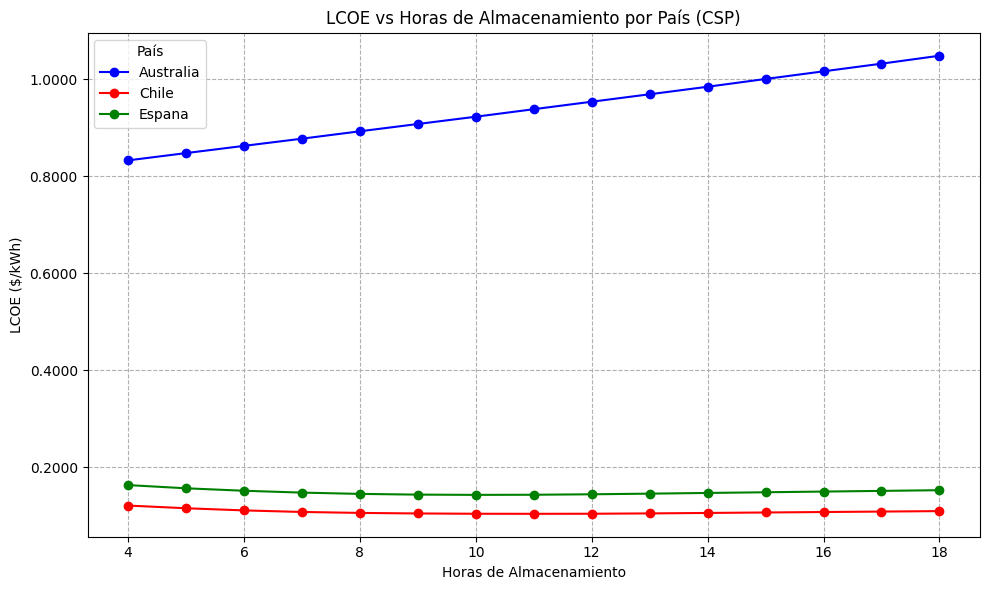

Gráfico comparativo LCOE vs Horas guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_lcoe_vs_horas_csp.png


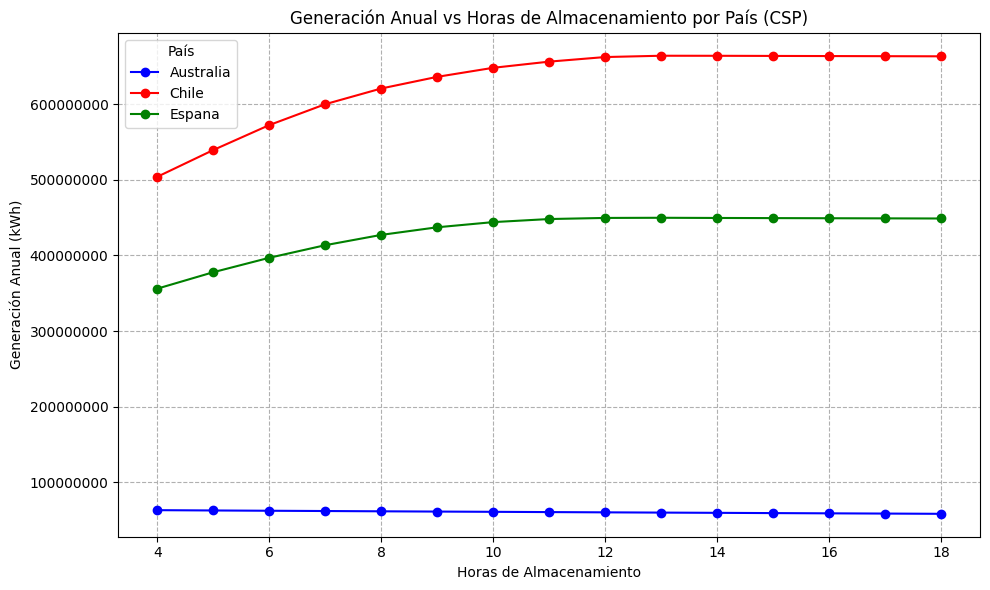

Gráfico comparativo Energía vs Horas guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_energia_vs_horas_csp.png


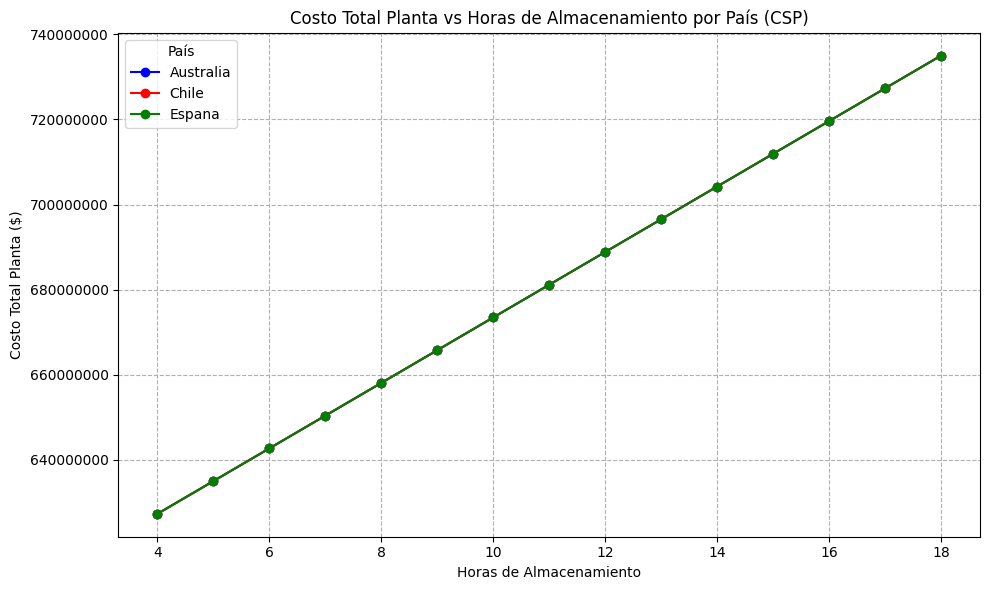

Gráfico comparativo Costo vs Horas guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_costo_vs_horas_csp.png


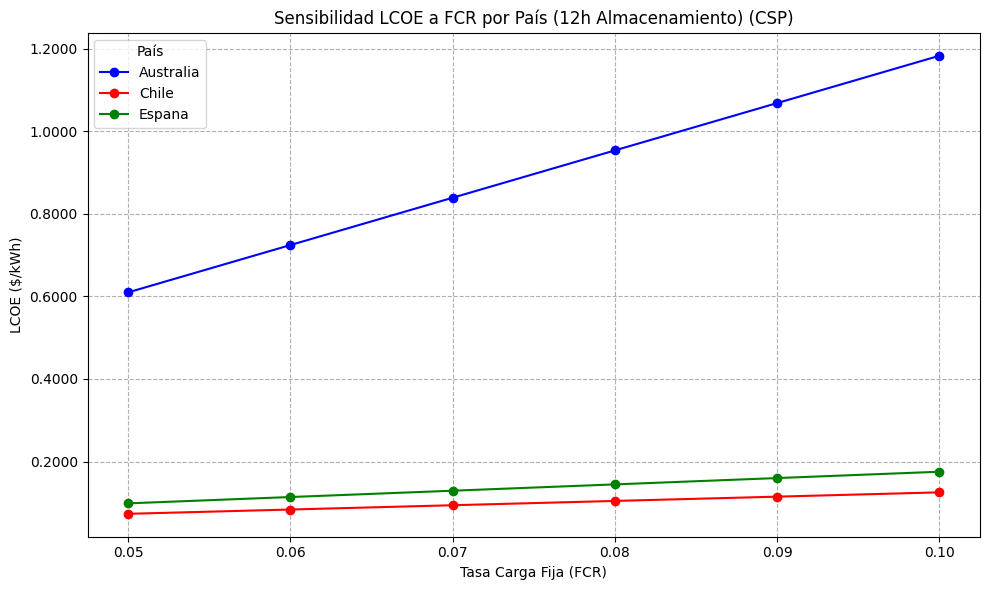

Gráfico comparativo Sensibilidad LCOE vs FCR guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_sensibilidad_lcoe_vs_fcr_csp.png


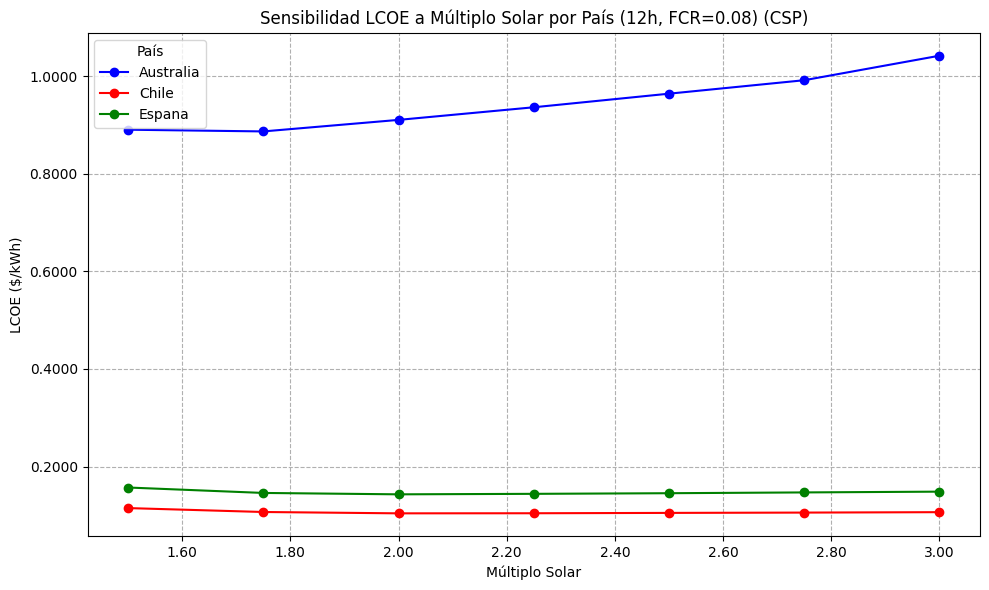

Gráfico comparativo Sensibilidad LCOE vs Múltiplo Solar guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_sensibilidad_lcoe_vs_solarm_csp.png
--------------------------------------------------
Generación de gráficos comparativos finalizada.


In [21]:
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm)